<a href="https://colab.research.google.com/github/BrandonYChan/Plant-Disease-Deep_Learning/blob/main/Plant_Model_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Classification Model

## Imports

In [ ]:
!pip install gradio
# !pip install tensorflow==2.16.2
# !pip install tensorflow-datasets
import tensorflow as tf, tensorflow_datasets as tfds, keras
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os, zipfile
from google.colab import drive
from PIL import Image
import requests, gradio as gr

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 879.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━

In [ ]:
print(tfds.__version__)

4.9.6


## Dataset

In [ ]:
# split_ratio = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
# datasets, info = tfds.load('plant_leaves', with_info=True, split=split_ratio, as_supervised=True)
# (train, validation, test) = datasets
# print(info)
split_ratio = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
dbuilder = tfds.builder('plant_leaves')
# dbuilder.download_and_prepare()
datasets = dbuilder.as_data_source(split=split_ratio)
(train, validation, test), info = datasets, dbuilder.info
print(info)

def array_record_to_tf_dataset(array_record):
    def generator():
        for example in array_record:
            yield example['image'], example['label']  # Yield image and label as a tuple

    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    )

train = array_record_to_tf_dataset(train)
validation = array_record_to_tf_dataset(validation)
test = array_record_to_tf_dataset(test)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/4502 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_leaves/incomplete.PXOPFE_0.1.1/plant_leaves-train.array_record*...: …

Dataset plant_leaves downloaded and prepared to /root/tensorflow_datasets/plant_leaves/0.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='plant_leaves',
    full_name='plant_leaves/0.1.1',
    description="""
    This dataset consists of 4502 images of healthy and unhealthy plant leaves
    divided into 22 categories by species and state of health. The images are in
    high resolution JPG format.
    
    There are no files with label prefix 0000, therefore label encoding is shifted
    by one (e.g. file with label prefix 0001 gets encoded label 0).
    
    Note: Each image is a separate download. Some might rarely fail, therefore make
    sure to restart if that happens. An exception will be raised in case one of the
    downloads repeatedly fails.
    
    Dataset URL: https://data.mendeley.com/datasets/hb74ynkjcn/1 License:
    http://creativecommons.org/licenses/by/4.0
    """,
    homepage='https://data.mendeley.com/datasets/hb74ynkjcn/1',
    data_di

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
def preprocess(image, label):
  image = tf.image.resize(image, (224, 224))
  image = image / 255.0
  label = tf.where(label < 12, 0, 1)
  return image, label

train = train.map(preprocess).batch(32)
validation = validation.map(preprocess).batch(32)
test = test.map(preprocess).batch(32)
print(info)
for images, labels in train.take(1):
    print(images.shape, labels.shape)

tfds.core.DatasetInfo(
    name='plant_leaves',
    full_name='plant_leaves/0.1.1',
    description="""
    This dataset consists of 4502 images of healthy and unhealthy plant leaves
    divided into 22 categories by species and state of health. The images are in
    high resolution JPG format.
    
    There are no files with label prefix 0000, therefore label encoding is shifted
    by one (e.g. file with label prefix 0001 gets encoded label 0).
    
    Note: Each image is a separate download. Some might rarely fail, therefore make
    sure to restart if that happens. An exception will be raised in case one of the
    downloads repeatedly fails.
    
    Dataset URL: https://data.mendeley.com/datasets/hb74ynkjcn/1 License:
    http://creativecommons.org/licenses/by/4.0
    """,
    homepage='https://data.mendeley.com/datasets/hb74ynkjcn/1',
    data_dir=PosixGPath('/tmp/tmpe22ctjh0tfds'),
    file_format=array_record,
    download_size=6.56 GiB,
    dataset_size=6.81 GiB,
    featur

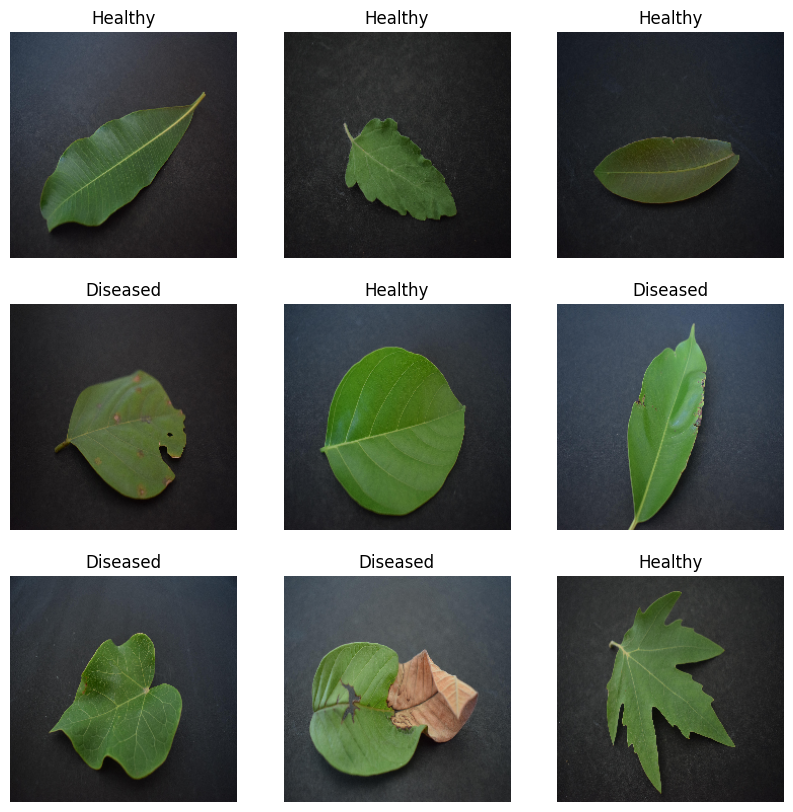

In [ ]:
def plot_images(images, img_labels):
    plt.figure(figsize=(10, 10))
    for images, labels in train.take(1):
        images = images.numpy()
        labels = labels.numpy()
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(img_labels[int(labels[i])])
            plt.axis("off")
    plt.show()


plot_images(train, ['Healthy', 'Diseased'])

## Model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(224, 224, 3)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=128, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
)
model.fit(
    train,
    epochs=10,
    validation_data=validation,
)

113/113 [==============================] - 978s 9s/step - loss: 0.6987 - accuracy: 0.5550 - val_loss: 0.6453 - val_accuracy: 0.6556


In [ ]:
test_loss, test_accuracy = model.evaluate(test)
print(f'Test accuracy: {test_accuracy}')

15/15 [==============================] - 111s 7s/step - loss: 0.6431 - accuracy: 0.7089
Test accuracy: 0.7088888883590698


## Gradio App

In [ ]:
# Functions for Gradio App

def download_image(image_url, save_path='temp_image.jpg'):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        return save_path
    else:
        print(f'Failed to download image from URL: {image_url}')
        return None

def predict_disease(image_source):
    # Check if image_source is a URL or a local path
    if image_source.startswith('http'):
        # Download the image if it's a URL
        image_path = download_image(image_source)
        if image_path is None:
            return None
    else:
        # Use the local path directly
        image_path = image_source

    # Load the image and preprocess it
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)

    # Make the prediction
    prediction = model.predict(img)
    predicted_class = (prediction > 0.5).astype("int32")[0][0]
    predicted_class = "Diseased" if predicted_class==1 else "Healthy"

    img = Image.open(image_path)
    img = img.resize((224, 224))

    plot = plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Remove the temporary file if it was downloaded
    if image_source.startswith('http'):
        os.remove(image_path)


  # Return the predicted disease
    return predicted_class, plot

In [ ]:
#Gradio App

# !pip install gradio
import gradio as gr

demo = gr.Interface(
    fn=predict_disease,
    inputs=["text"],
    outputs=["text", "plot"]
)
demo.launch()
# https://plantwiseplusknowledgebank.org/cms/10.1079/pwkb.20137804388/asset/8ae7944d-9d9c-4610-9531-83a94f842640/assets/graphic/f253ddf3-a54b-4530-b27c-a887c761ce0f.jpg

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2eb0cc217c56a1304b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
